<a href="https://colab.research.google.com/github/MarioSigal/Modelado-Continuo/blob/main/Colabs/nb08_DFT%2BFFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introducción al modelado continuo** (*a.k.a.* **Ecuaciones de la física matemática**)
## Laboratorio numérico 2024

Bienvenidos al laboratorio numérico de la materia *Introducción al modelado continuo*, también conocida como *Ecuaciones de la física matemática*. En este, vamos a ver métodos numéricos para resolver distintos tipos de problemas de manera general, y su relación y aplicación a problemas específicos de la materia, de manera tal de complementar los contenidos de la cursada teórico-práctica.

# Motivación de este colab
<!-- $$\require{amsmath}$$ -->

La **transformada de Fourier**, en el marco de las trasnformaciones integrales de variables continuas usando un kernel de Fourier, es una herramienta con grandes aplicaciones en la resolución de problemas de la física matemática con cierto tipo de condiciones de contorno. Permite resolver problemas complicados o incluso que no tienen solución directa, a partir de transformar el problema, resolver el problema en el espacio transoformado, y anti-transformar para encontrar la solución en el espacio original. En la clase teórica vimos como esto nos permitía obtener las soluciones de ecuaciones diferenciales en derivadas parciales (PDEs) a partir de resolver en el espacio transformado ecuaciones diferenciales ordinarias (ODEs), como las que vimos durante el 1er eje temático. Esto nos permitía resolver problemas de sistemas físicos tradicionales como la ecuación del calor o la ecuación de ondas. Así mismo, también vimos que este tipo de estrategias nos permitía resolver de manera parsimoniosa el oscilador forzado, debido a la naturaleza periódica del problema. Entonces, vimos la potencia de la transformada de Fourier en aplicaciones matemáticas para variables continuas.

Ahora, qué pasa cuando tengo una representación discreta de variables, es decir, datos? En este colab vamos a revisar algunos conceptos de la transformada desde la perspectiva numérica, y vamos a explorar la transformada de Fourier en el contexto de aplicación a señales. Vamos a reforzar la interpretación de la transformada de una señal discreta en este marco, y cómo adaptarla. Esto nos va a llevar a definir la **transformada discreta de Fourier (DFT)**, destacando el algoritmo de la **transformada rápida de Fourier (FFT)** como estrategia para poder computarla de manera eficiente y menos costosa.


---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

---
# Generalización de series de Fourier para funciones periódicas

En el colab pasado vimos la representación en series de Fourier para funciones periódicas con período $2 \pi$. Estas expansiones se pueden extender a funciones periódicas con período $2L$ con la siguiente expresión:

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n cos \left( \frac{n \pi x}{L} \right) + \sum_{n=1}^{\infty} b_n sin \left( \frac{n \pi x}{L} \right)
$$

Donde los coeficientes están relacionados con la función periódica f(x) mediante integrales definidas:

$$
a_n = \frac{1}{L} \int_{-L}^{L} f(x) cos \left( \frac{n \pi x}{L} \right) dx \\
b_n = \frac{1}{L} \int_{-L}^{L} f(x) sin \left( \frac{n \pi x}{L} \right) dx
$$

El cálculo de los coeficientes se resuelve de manera análoga que para el caso en el que el período es $2 \pi$.

Noten que para generalizar a funciones periódicas con período $2L$ tuvimos que adaptar la periodicidad de las funciones ortogonales de la base de senos y cosenos para que tengan período $2L$ (cambiando la expresión de su argumento), y también tuvimos que cambiar el factor multiplicativo por un tema de normalización de la base.

Las series de Fourier, de manera más general, permiten analizar funciones periódicas de cualquier período, descomponiéndolas en una suma infinita de funciones armónicas. Los coeficientes expresan la cantidad de cada una de las señales armónicas puras que se deben sumar para obtener la señal analizada.


## Ejercicio 1

Sea la función $f_1(x)=sin(\pi x)+2sin(3\pi x)$

1.1. Qué período tiene? Haga el gráfico para varios períodos.

1.2. Calcule los coeficientes del desarrollo de Fourier hasta el orden 8. Haga el gráfico de los coeficientes en función de la frecuencia discreta (o del n, por simplicidad). Es lo que esperaba encontrar? Haga también el gráfico de $\sqrt{a_n^2+b_n^2}$.

1.3. Repita el análisis para $f_2(x)=sin(4\pi x)+2sin(2\pi x)$.


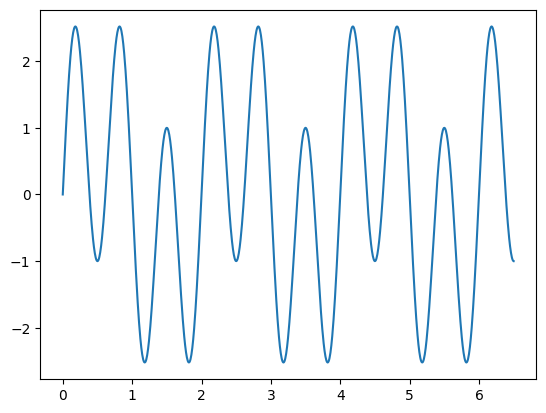

In [5]:
f = lambda x: np.sin(np.pi*x)+2*np.sin(3*np.pi*x)
x = np.linspace(0, 6.5, 1000)
plt.plot(x, f(x))
plt.show()

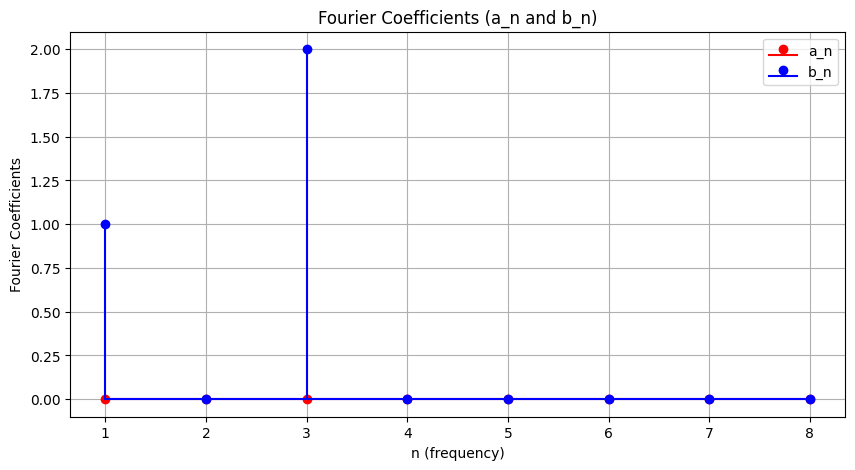

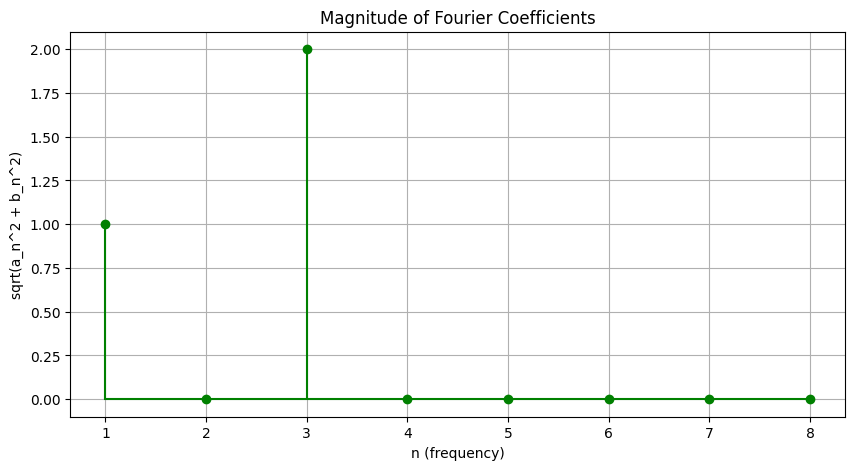

In [7]:

L = 1
N = 8

a_n = np.zeros(N + 1)
b_n = np.zeros(N + 1)

for n in range(1, N + 1):
    a_n[n] = (1/L) * np.trapz(f(np.linspace(-L, L, 1000)) * np.cos(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000))
    b_n[n] = (1/L) * np.trapz(f(np.linspace(-L, L, 1000)) * np.sin(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000))

#Plot coefficients
n_values = np.arange(1, N+1)
plt.figure(figsize=(10,5))
plt.stem(n_values, a_n[1:], linefmt='r-', markerfmt='ro', basefmt='r-') # a_n coefficients
plt.stem(n_values, b_n[1:], linefmt='b-', markerfmt='bo', basefmt='b-') # b_n coefficients
plt.xlabel('n (frequency)')
plt.ylabel('Fourier Coefficients')
plt.title('Fourier Coefficients (a_n and b_n)')
plt.legend(['a_n', 'b_n'])
plt.grid(True)
plt.show()


# Calculate sqrt(a_n^2 + b_n^2)
c_n = np.sqrt(a_n[1:]**2 + b_n[1:]**2)

# Plot sqrt(a_n^2 + b_n^2)
plt.figure(figsize=(10,5))
plt.stem(n_values, c_n, linefmt='g-', markerfmt='go', basefmt='g-')
plt.xlabel('n (frequency)')
plt.ylabel('sqrt(a_n^2 + b_n^2)')
plt.title('Magnitude of Fourier Coefficients')
plt.grid(True)
plt.show()

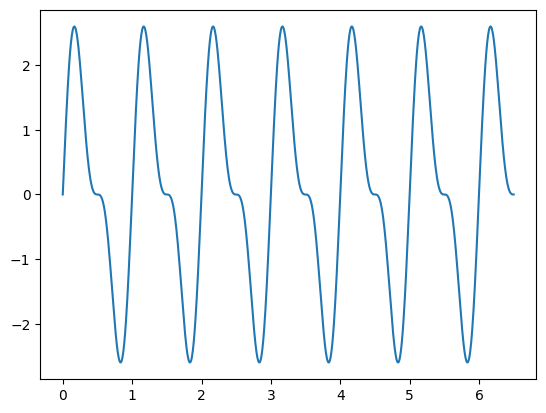

In [9]:
f2 = lambda x: np.sin(4*np.pi*x)+2*np.sin(2*np.pi*x)
x = np.linspace(0, 6.5, 1000)
plt.plot(x, f2(x))
plt.show()

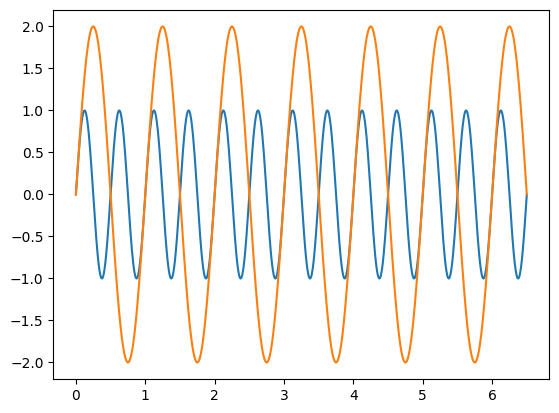

In [11]:
x = np.linspace(0, 6.5, 1000)
plt.plot(x, np.sin(4*np.pi*x))
plt.plot(x, 2*np.sin(2*np.pi*x))
plt.show()

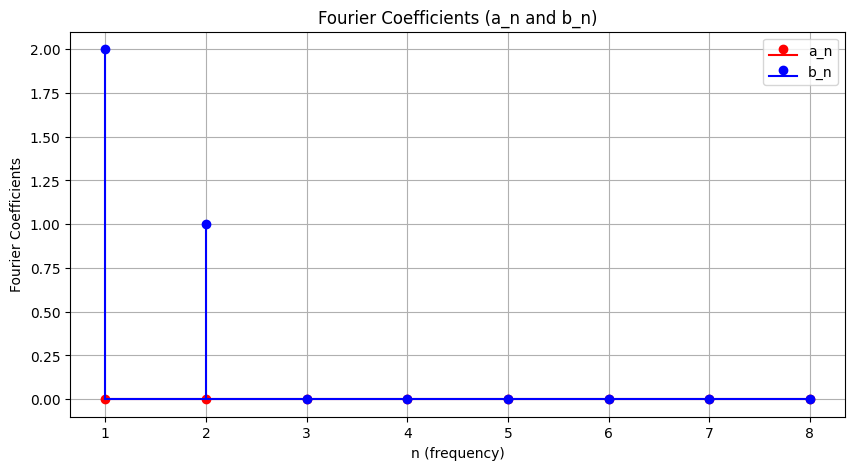

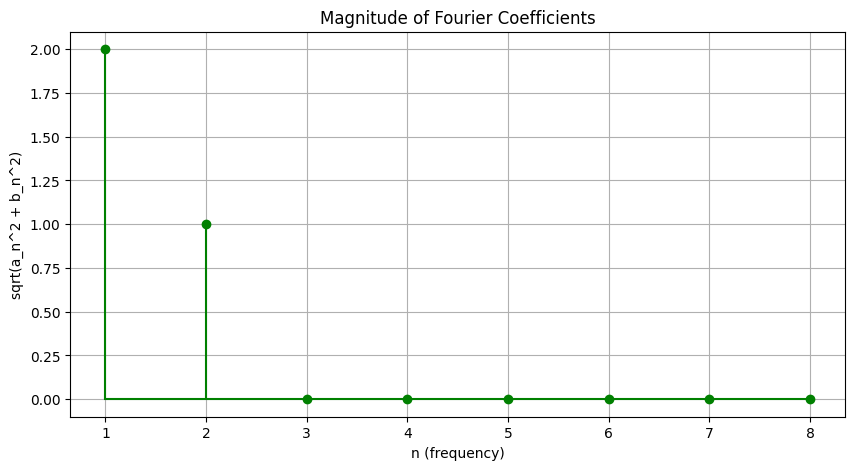

In [10]:

L = 0.5
N = 8

a_n = np.zeros(N + 1)
b_n = np.zeros(N + 1)

for n in range(1, N + 1):
    a_n[n] = (1/L) * np.trapz(f2(np.linspace(-L, L, 1000)) * np.cos(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000))
    b_n[n] = (1/L) * np.trapz(f2(np.linspace(-L, L, 1000)) * np.sin(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000))

#Plot coefficients
n_values = np.arange(1, N+1)
plt.figure(figsize=(10,5))
plt.stem(n_values, a_n[1:], linefmt='r-', markerfmt='ro', basefmt='r-') # a_n coefficients
plt.stem(n_values, b_n[1:], linefmt='b-', markerfmt='bo', basefmt='b-') # b_n coefficients
plt.xlabel('n (frequency)')
plt.ylabel('Fourier Coefficients')
plt.title('Fourier Coefficients (a_n and b_n)')
plt.legend(['a_n', 'b_n'])
plt.grid(True)
plt.show()


# Calculate sqrt(a_n^2 + b_n^2)
c_n = np.sqrt(a_n[1:]**2 + b_n[1:]**2)

# Plot sqrt(a_n^2 + b_n^2)
plt.figure(figsize=(10,5))
plt.stem(n_values, c_n, linefmt='g-', markerfmt='go', basefmt='g-')
plt.xlabel('n (frequency)')
plt.ylabel('sqrt(a_n^2 + b_n^2)')
plt.title('Magnitude of Fourier Coefficients')
plt.grid(True)
plt.show()

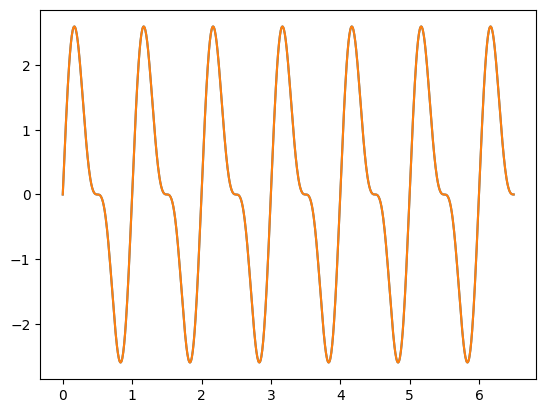

In [13]:
f3 = lambda x: 2*np.sin(1*np.pi*x/L) + 1*np.sin(2*np.pi*x/L)
x = np.linspace(0, 6.5, 1000)
plt.plot(x, f3(x))
plt.plot(x, f2(x))
plt.show()

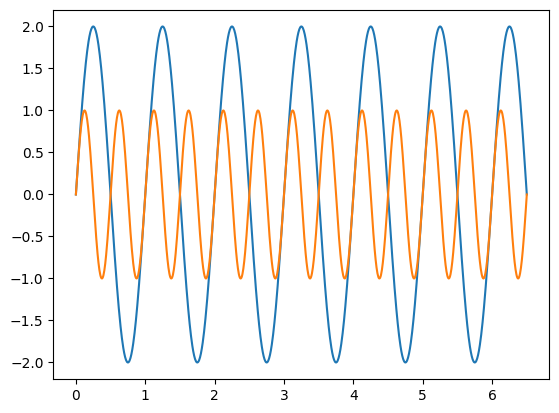

In [14]:
x = np.linspace(0, 6.5, 1000)
plt.plot(x, 2*np.sin(1*np.pi*x/L))
plt.plot(x, 1*np.sin(2*np.pi*x/L))
plt.show()




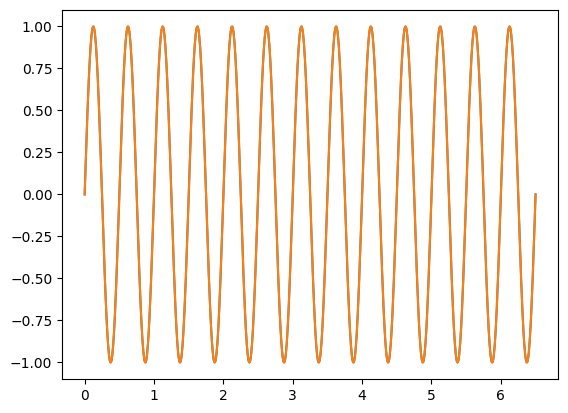

In [16]:
x = np.linspace(0, 6.5, 1000)
plt.plot(x, np.sin(4*np.pi*x))
plt.plot(x, 1*np.sin(2*np.pi*x/L))
plt.show()

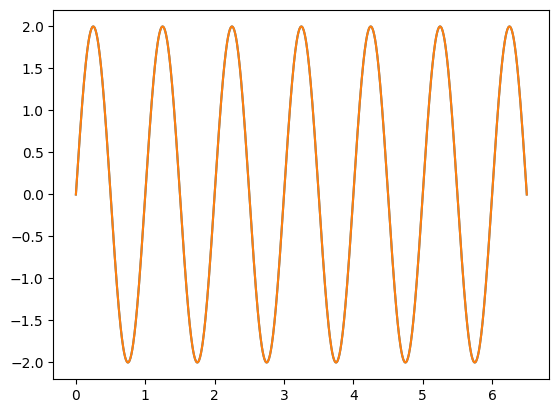

In [17]:
x = np.linspace(0, 6.5, 1000)
plt.plot(x, 2*np.sin(1*np.pi*x/L))
plt.plot(x, 2*np.sin(2*np.pi*x))
plt.show()

---
# Generalización de series de Fourier para funciones no periódicas

De la misma manera que para funciones periódicas, se puede plantear la expansión para funciones no periódicas pero definidas en un intervalo $[-L, L]$, aprovechando las condiciones de contorno del intervalo. Esto se hace extendiendo la función como si se repitiese fuera del intervalo, de manera tal que pueda considerarse a la función como periódica con periodo $2L$. La expansión de Fourier para funciones no periódicas en $[-L, L]$ permite representar cualquier función en ese intervalo mediante una suma infinita de senos y cosenos. Aunque no es una representación extrictamente periódica, su construcción en el intervalo finito implica que, fuera de $[-L, L]$, la función se "extiende" periódicamente. La expansión y los coeficientes se pueden calcular por lo tanto de manera análoga a lo visto para funciones periódicas.

$$
f(x) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n cos \left( \frac{n \pi x}{L} \right) + \sum_{n=1}^{\infty} b_n sin \left( \frac{n \pi x}{L} \right) \\
a_n = \frac{1}{L} \int_{-L}^{L} f(x) cos \left( \frac{n \pi x}{L} \right) dx \\
b_n = \frac{1}{L} \int_{-L}^{L} f(x) sin \left( \frac{n \pi x}{L} \right) dx
$$

Los coeficientes representan las amplitudes de las frecuencias $\frac{n \pi}{L}$ que componen la señal.

---
## Paridad de las funciones

La paridad de funciones se refiere a la simetría de una función con respecto al origen o al eje vertical. Una función $f(x)$ es **par** si cumple $f(x) = f(-x)$ para todo $x$, lo que significa que su gráfica es simétrica respecto al eje $y$. En cambio, es **impar** si satisface $f(x) = -f(-x)$, lo que implica que su gráfica es simétrica respecto al origen. Esto hace que las integrales en los intervalos $[-L, 0]$ y $[0, L]$ tengan una relación entre sí. Usando la regla de trapezio compuesta, calculemos las integrales en estos sub-intervalos para varios valores de L distintos, para una función par como $f(x)=x^{2}$, definida en el intervalo $[-L, L]$, y veamos cómo es la relación entre integrales.

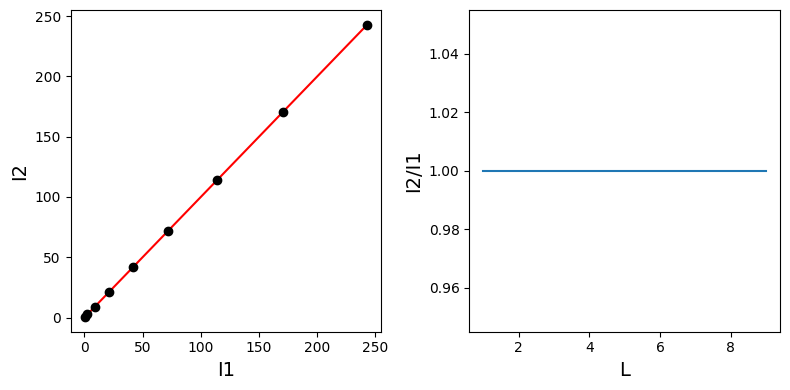

In [18]:
def f(x):
    return x**2

I1 = []
I2 = []
Ls = np.arange(9)+1
for L in Ls:
    x_mitad1 = np.linspace(-L, 0, 1000)
    I_mitad1 = np.trapz(f(x_mitad1), x_mitad1)
    x_mitad2 = np.linspace(0, L, 1000)
    I_mitad2 = np.trapz(f(x_mitad2), x_mitad2)
    I1.append(I_mitad1)
    I2.append(I_mitad2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(I1, I1, 'r-')
plt.plot(I1, I2, 'ko')
plt.ylabel('I2', fontsize=14)
plt.xlabel('I1', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(Ls, np.array(I2)/np.array(I1))
plt.ylabel('I2/I1', fontsize=14)
plt.xlabel('L', fontsize=14)
plt.tight_layout()
plt.show()

Veamos qué pasa ahora para una función impar como $f(x)=x^{3}$, definida en el intervalo $[-L, L]$.

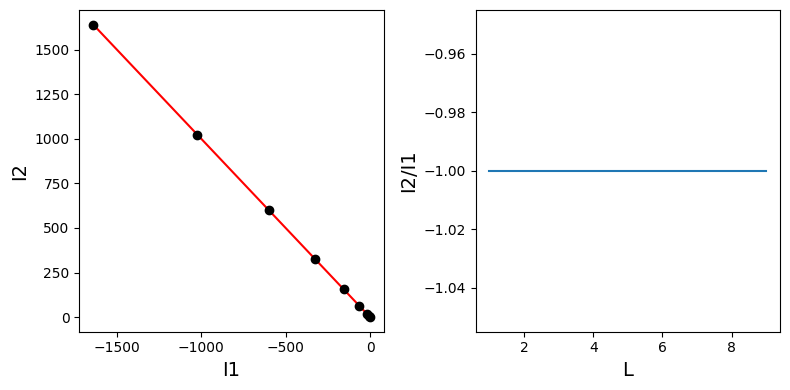

In [19]:
def f(x):
    return x**3

I1 = []
I2 = []
Ls = np.arange(9)+1
for L in Ls:
    x_mitad1 = np.linspace(-L, 0, 1000)
    I_mitad1 = np.trapz(f(x_mitad1), x_mitad1)
    x_mitad2 = np.linspace(0, L, 1000)
    I_mitad2 = np.trapz(f(x_mitad2), x_mitad2)
    I1.append(I_mitad1)
    I2.append(I_mitad2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(I1, -np.array(I1), 'r-')
plt.plot(I1, I2, 'ko')
plt.ylabel('I2', fontsize=14)
plt.xlabel('I1', fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(Ls, np.array(I2)/np.array(I1))
plt.ylabel('I2/I1', fontsize=14)
plt.xlabel('L', fontsize=14)
plt.tight_layout()
plt.show()

### Ejercicio 2

2.1. Como resultado de esta relación, se muestra que las integrales de funciones impares en el intervalo $[-L,L]$ son 0, ya que las integrales entre $[-L, 0]$ y $[0, L]$ se cancelan entre sí. Compruébelo con la función $f(x)=x^{3}$.

2.2. Usando la regla del trapecio, calcule las integrales de $cos \left( \frac{n \pi x}{L} \right)$ y $sin \left( \frac{n \pi x}{L} \right)$ en el intervalo $[-L, L]$. Espera que alguna sea 0? Piense la respuesta en base a la paridad de las funciones trigonométricas.

2.3. Calcule ahora tanto para $f(x)=x^{2}$ como para $f(x)=x^{3}$, las integrales

$$
\int_{-L}^{L} f(x) cos \left( \frac{n \pi x}{L} \right) dx \\
\int_{-L}^{L} f(x) sin \left( \frac{n \pi x}{L} \right) dx
$$

Qué resultados espera encontrar? Piense en la paridad de una función $h(x)=f(x).g(x)$ para los casos de distinta paridad de las funciones $f(x)$ y $g(x)$. Para esto piense en los distintos casos cómo quedaría $h(-x)$. Explica esto los resultados obtenidos?

2.4. Qué implicancias tiene esta propiedad en el cálculo de coeficientes del desarrollo de Fourier? Calcule los coeficientes para $f(x)=x^{2}$ y para $f(x)=x^{3}$. Grafique los coeficientes encontrados en función del $n$.

In [24]:
def f(x):
    return x**3
L= 2
I = np.trapz(f(np.linspace(-L, L, 1000)), np.linspace(-L, L, 1000))
print(I)

8.881784197001252e-16


In [29]:
L = np.pi
N = 3

a_n = np.zeros(N + 1)
b_n = np.zeros(N + 1)

for n in range(1, N + 1):
    a_n[n] = (1/L) * np.trapz(np.cos(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000))
    b_n[n] = (1/L) * np.trapz(np.sin(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000))
    print(a_n[n], b_n[n])

7.067899292141149e-17 0.0
-3.533949646070574e-17 0.0
3.533949646070574e-17 0.0


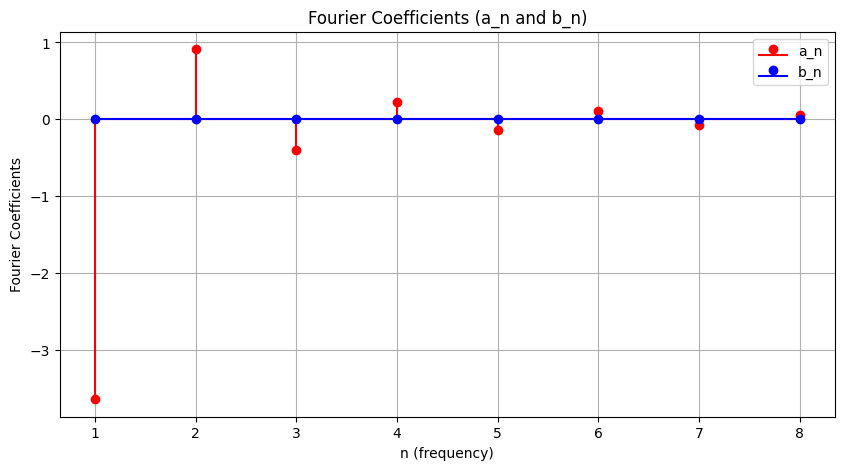

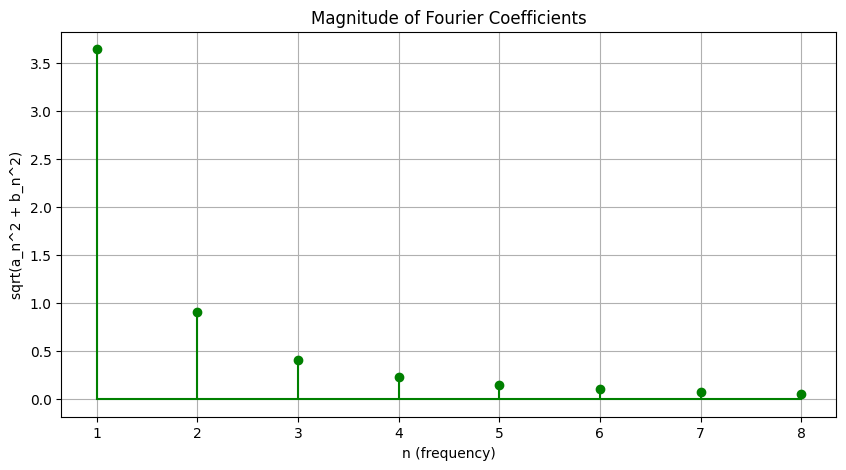

In [30]:
def f2(x):
    return x**2
L = 3
N = 8

a_n = np.zeros(N + 1)
b_n = np.zeros(N + 1)

for n in range(1, N + 1):
    a_n[n] = (1/L) * np.trapz(f2(np.linspace(-L, L, 1000)) * np.cos(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000)) #par * par = par
    b_n[n] = (1/L) * np.trapz(f2(np.linspace(-L, L, 1000)) * np.sin(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000)) #par * impar = impar

#Plot coefficients
n_values = np.arange(1, N+1)
plt.figure(figsize=(10,5))
plt.stem(n_values, a_n[1:], linefmt='r-', markerfmt='ro', basefmt='r-') # a_n coefficients
plt.stem(n_values, b_n[1:], linefmt='b-', markerfmt='bo', basefmt='b-') # b_n coefficients
plt.xlabel('n (frequency)')
plt.ylabel('Fourier Coefficients')
plt.title('Fourier Coefficients (a_n and b_n)')
plt.legend(['a_n', 'b_n'])
plt.grid(True)
plt.show()


# Calculate sqrt(a_n^2 + b_n^2)
c_n = np.sqrt(a_n[1:]**2 + b_n[1:]**2)

# Plot sqrt(a_n^2 + b_n^2)
plt.figure(figsize=(10,5))
plt.stem(n_values, c_n, linefmt='g-', markerfmt='go', basefmt='g-')
plt.xlabel('n (frequency)')
plt.ylabel('sqrt(a_n^2 + b_n^2)')
plt.title('Magnitude of Fourier Coefficients')
plt.grid(True)
plt.show()

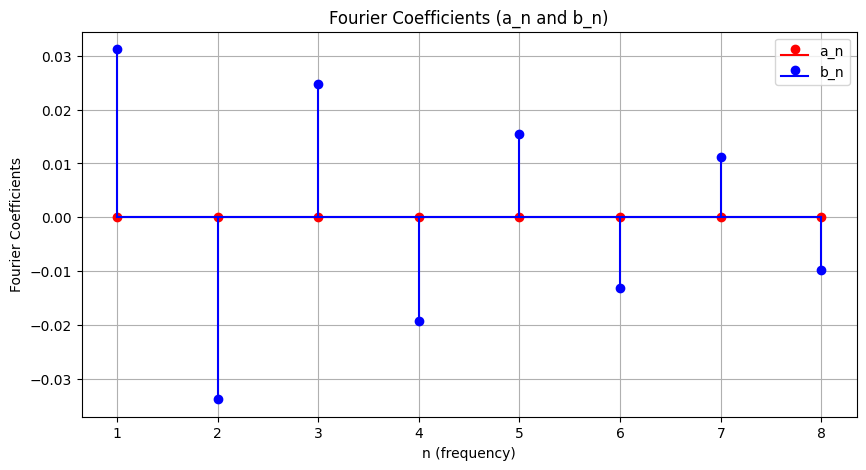

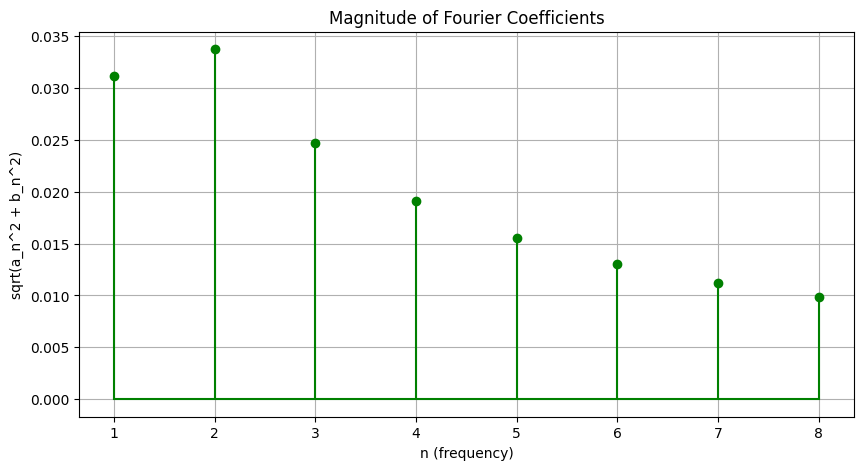

In [31]:
def f3(x):
    return x**3
L = 0.5
N = 8

a_n = np.zeros(N + 1)
b_n = np.zeros(N + 1)

for n in range(1, N + 1):
    a_n[n] = (1/L) * np.trapz(f3(np.linspace(-L, L, 1000)) * np.cos(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000)) # impar * par = impar
    b_n[n] = (1/L) * np.trapz(f3(np.linspace(-L, L, 1000)) * np.sin(n * np.pi * np.linspace(-L, L, 1000) / L), np.linspace(-L, L, 1000)) # impar * impar = par

#Plot coefficients
n_values = np.arange(1, N+1)
plt.figure(figsize=(10,5))
plt.stem(n_values, a_n[1:], linefmt='r-', markerfmt='ro', basefmt='r-') # a_n coefficients
plt.stem(n_values, b_n[1:], linefmt='b-', markerfmt='bo', basefmt='b-') # b_n coefficients
plt.xlabel('n (frequency)')
plt.ylabel('Fourier Coefficients')
plt.title('Fourier Coefficients (a_n and b_n)')
plt.legend(['a_n', 'b_n'])
plt.grid(True)
plt.show()


# Calculate sqrt(a_n^2 + b_n^2)
c_n = np.sqrt(a_n[1:]**2 + b_n[1:]**2)

# Plot sqrt(a_n^2 + b_n^2)
plt.figure(figsize=(10,5))
plt.stem(n_values, c_n, linefmt='g-', markerfmt='go', basefmt='g-')
plt.xlabel('n (frequency)')
plt.ylabel('sqrt(a_n^2 + b_n^2)')
plt.title('Magnitude of Fourier Coefficients')
plt.grid(True)
plt.show()

---
# Transformada de Fourier

La **transformada de Fourier** y la expansión de Fourier generalizada están directamente relacionadas. De hecho, la transformada de Fourier es una extensión de la serie de Fourier para funciones no periódicas y no acotadas. Esta extensión surge al considerar el límite de la serie de Fourier de una función cuando el intervalo de periodicidad se hace infinito.

Para entender esta relación, comencemos desde la expansión de Fourier en un intervalo finito $[-L, L]$ para una función $f(x)$:

$$
f(x) = \sum_{n=-\infty}^{\infty} c_n e^{i \frac{n \pi x}{L}}
$$

donde los coeficientes de Fourier son:

$$
c_n = \frac{1}{2L} \int_{-L}^{L} f(x) e^{-i \frac{n \pi x}{L}} \, dx
$$

En esta expresión, las frecuencias $\frac{n \pi}{L}$ son discretas debido al intervalo acotado $[-L, L]$. A medida que $L \to \infty$, el intervalo de definición se extiende a todo el eje real, el período tiende a infinito, y la separación entre las frecuencias $\frac{\pi}{L}$ se vuelve infinitesimal, convirtiendo las frecuencias discretas en un continuo de frecuencias $\xi$.

Al tomar el límite $L \to \infty$, la serie de Fourier se transforma en una integral en lugar de una suma, y los coeficientes discretos $c_n$ se convierten en la función continua $\hat{f}(\xi)$ en el dominio de frecuencias, donde:

$$
\hat{f}(\xi) = \lim_{L \to \infty} \frac{1}{2L} \int_{-L}^{L} f(x) e^{-i 2 \pi \xi x} \, dx
$$

Esto da lugar a la transformada de Fourier:

$$
\hat{f}(\xi) = \int_{-\infty}^{\infty} f(x) e^{-i 2 \pi \xi x} \, dx
$$

La transformada de Fourier puede verse como una generalización continua de la expansión de Fourier. Mientras que una serie de Fourier descompone una función periódica en frecuencias discretas, la transformada de Fourier descompone una función no periódica (o periódica en el infinito) en un continuo de frecuencias.

La transformada de Fourier permite analizar funciones en todo el eje real, algo que la serie de Fourier no puede hacer sin imponer periodicidad artificial. Es, en otras palabras, el límite de la expansión de Fourier para funciones no acotadas en un intervalo finito, lo que permite estudiar frecuencias continuas en lugar de discretas.

De esta manera, si consideramos el período $T=2L$, podemos ver los coeficientes $c_n$ de la serie de Fourier como muestras discretas de la transformada de Fourier continua en un conjunto específico de frecuencias $\xi_n = \frac{n}{T}$:

$$
c_n = \frac{1}{T} \hat{f}\left(\frac{n}{T}\right)
$$

A medida que $T \to \infty$, los coeficientes $c_n$ se convierten en puntos de la transformada continua, generando un espectro continuo que se vuelve denso en el espacio de frecuencias.


---
# Transformada de Fourier discreta (DFT)

La **transformada de Fourier discreta (DFT)** puede interpretarse como una versión discretizada de la transformada de Fourier (con tiempo y frecuencias discretas), que surge al muestrear tanto en el tiempo como en la frecuencia. Acá es importante diferenciarla de la serie de Fourier para desambiguar y evitar confusiones. La serie de Fourier representa una función en términos de frecuencias discretas, pero continuas en el dominio del tiempo. Por el contrario, la DFT aplica a un conjunto finito de datos (muestras discretas en el tiempo), no a una función continua.

Dada una secuencia discreta de datos $x = [x_0, x_1, \ldots, x_{N-1}]$ de longitud $N$, la DFT de esta secuencia produce otra secuencia de $N$ elementos $X = [X_0, X_1, \ldots, X_{N-1}]$, donde cada $X_k$ representa una frecuencia específica de la señal. La DFT se define como:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{-i \frac{2 \pi k n}{N}}
$$

En notación matricial, esto se puede escribir como:

$$
X = W \cdot x
$$

donde $W$ es una **matriz de DFT** de tamaño $N \times N$, cuyas entradas están dadas por:

$$
W_{kn} = e^{-i \frac{2 \pi k n}{N}}
$$

Si definimos $\omega = e^{-i \frac{2 \pi}{N}}$, entonces $W_{kn} = \omega^{kn}$, y la forma explícita de la matriz $W$ es:

$$
W = \begin{bmatrix}
1 & 1 & 1 & \dots & 1 \\
1 & \omega & \omega^2 & \dots & \omega^{N-1} \\
1 & \omega^2 & \omega^4 & \dots & \omega^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega^{N-1} & \omega^{2(N-1)} & \dots & \omega^{(N-1)(N-1)}
\end{bmatrix}
$$


## Ejercicio 3

3.1. Escriba una función de Python que reciba como entrada un array y haga el cálculo de la DFT usando el comando `for`.

3.2. Escriba una función de Python que reciba como entrada un array y haga el cálculo de la DFT usando álgebra lineal de matrices.

3.3. Pruebe ambas funciones dándole como entrada vectores aleatorios de 128, 512, y 1024 de largo. Para cada uno de los casos, calcule y compare los tiempos de cómputo.


In [32]:
# prompt: Escriba una función de Python que reciba como entrada un array y haga el cálculo de la DFT usando el comando for.

import numpy as np

def DFT_for(x):
  N = len(x)
  X = np.zeros(N, dtype=complex)
  for k in range(N):
    for n in range(N):
      X[k] += x[n] * np.exp(-1j * 2 * np.pi * k * n / N)
  return X

In [36]:
# prompt:  Escriba una función de Python que reciba como entrada un array y haga el cálculo de la DFT usando álgebra lineal de matrices

import numpy as np

def DFT_matrix(x):
  N = len(x)
  W = np.zeros((N, N), dtype=complex)
  for k in range(N):
    for n in range(N):
      if W[k][n] == 0:
        wkn = np.exp(-1j * 2 * np.pi * k * n / N)
        W[k][n] = wkn
        W[k][n] = wkn
  X = np.dot(W, x)
  return X

In [37]:
# prompt: Pruebe ambas funciones dándole como entrada vectores aleatorios de 128, 512, y 1024 de largo. Para cada uno de los casos, calcule y compare los tiempos de cómputo.

import numpy as np
import time

# Test cases
lengths = [128, 512, 1024]

for N in lengths:
  x = np.random.rand(N)

  # Time DFT_for
  start_time = time.time()
  X_for = DFT_for(x)
  end_time = time.time()
  time_for = end_time - start_time

  # Time DFT_matrix
  start_time = time.time()
  X_matrix = DFT_matrix(x)
  end_time = time.time()
  time_matrix = end_time - start_time

  print(f"N = {N}")
  print(f"DFT_for time: {time_for:.6f} seconds")
  print(f"DFT_matrix time: {time_matrix:.6f} seconds")
  print("-" * 20)

N = 128
DFT_for time: 0.036039 seconds
DFT_matrix time: 0.044120 seconds
--------------------
N = 512
DFT_for time: 0.567276 seconds
DFT_matrix time: 0.604191 seconds
--------------------
N = 1024
DFT_for time: 2.097212 seconds
DFT_matrix time: 2.392022 seconds
--------------------


## Ejercicio 4

Encuentre la DFT de los siguientes vectores:
a) [0,1,0,−1]; b) [1,1,1,1]; c) [0,−1,0,1]; d) [0,1,0,−1,0,1,0,−1]

In [ ]:
# # # COMPLETAR

---
# Transformada Rápida de Fourier (FFT)

La FFT es una implementación eficiente de la DFT, que reduce significativamente el tiempo de cálculo. Uno de los algoritmos más utilizados para la FFT es el algoritmo de Cooley-Tukey propuesto en 1965. La DFT directa requiere $O(N^2)$ operaciones, mientras que la FFT reduce esto a $O(N \log N)$, haciéndola mucho más eficiente para señales largas. De hecho, cuando el N es muy grande, escala “casi linealmente” con el tamaño de N.

El algoritmo consiste básicamente en la aplicación de la estrategia *divide & conquer*, que divide la secuencia original en secuencias cada vez más chicas y las transforma recursivamente. Esto lo hace separando la señal en las componentes pares e impares, y calculando la DFT de cada mitad. Esto se repite recursivamente y, finalmente, se combinan los resultados para obtener la transformada completa.

Si tengo la transoformada X de un vector x, de tamaño N, puedo reescribirlo como:

$$
X = W_N . x = \begin{bmatrix}
I_{N/2} & -D_{N/2} \\
I_{N/2} & -D_{N/2} \\
\end{bmatrix} \begin{bmatrix}
W_{N/2} & 0 \\
0 & W_{N/2} \\
\end{bmatrix}
\begin{bmatrix}
x_{pares} \\
x_{impares} \\
\end{bmatrix}
$$

con

$$
D_N = \begin{bmatrix}
1 & 0 & 0 & \dots & 0 \\
0 & \omega & 0 & \dots & 0 \\
0 & 0 & \omega^2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & \omega^{(N-1)}
\end{bmatrix}
$$

Esto se puede repetir recursivamente, hasta llegar a $W_2$, permitiendo un mecanismo simple de la resolución del problema.

De esta manera, el algoritmo se plantea para valores de N que son potencias de 2, tal que se puedan separar de a mitades. Pero incluso si N no es una potencia de 2, se pueden completar los datos con ceros hasta llegar a la potencia de 2 más cercana y usar este algoritmo, que seguirá siendo una estrategia más eficiente que computar la DFT de manera directa.

Además de la bibliografía recomendada [Arfken et al 2012; Sauer 2012; Brunton & Kutz 2019], pueden encontrar material complementario en los siguientes links acerca de la [interpretación visual de la transformada](https://www.youtube.com/watch?v=h4PTucW3Rm0); la [historia de la FFT](https://www.youtube.com/watch?v=nmgFG7PUHfo); una [explicación de la FFT](https://www.youtube.com/watch?v=toj_IoCQE-4&list=PLMrJAkhIeNNT_Xh3Oy0Y4LTj0Oxo8GqsC); una [explicación más detallada de la FFT con la estrategia divide and conquer](https://www.youtube.com/watch?v=h7apO7q16V0); una [explicación mucho más detallada](https://www.youtube.com/watch?v=iTMn0Kt18tg) (las últimas 2 son un poco excesivas).


Veamos una forma de escribir el código de la función y comparemos el resultado con el obtenido de la función de Numpy

In [ ]:
def fft_cod(x):
    N = len(x)
    if N <= 1:
        return x
    else:
        X_even = fft_cod(x[0::2])
        X_odd = fft_cod(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even - factor[:N // 2] * X_odd])

In [ ]:
x = np.random.random(1024)

# Verificación de la implementación
X_fft = fft_cod(x)
X = np.fft.fft(x)
print("FFT calculada recursivamente:", X_fft)
print("FFT con numpy:", X)  # Comparación con la función de NumPy


## Ejercicio 5

Genere una onda cuadrada de cierta periodicidad, y encuentre el espectro discreto de Fourier usando `np.fft.fft`. La conversión de las frecuencias no es tan trivial, por lo que busque en la documentación cómo hacerlo. Discuta.


In [ ]:
# # # COMPLETAR

---
## Complejidad del método

La DFT directa requiere $O(N^2)$ operaciones, mientras que la FFT reduce esto a $O(N \log N)$.

### Ejercicio 6

Piense una manera de mostrar diferencias en el costo computacional de la DFT y la FFT. Pruebela. Una idea podría ser evaluar ambos métodos para distintos tamaños de vectorer de entrada generados de manera random.

In [ ]:
# # # COMPLETAR

# Aplicaciones matemáticas al cálculo de la derivada

Una aplicación matemática de la DFT es calcular la derivada de una función periódica en el dominio de la frecuencia. Por ejemplo, consideremos una función cuadrática $f(x)=x^{2}$ en un intervalo $[0, 2 \pi]$, evaluada en puntos equiespaciados. La derivada de esta función puede calcularse en el dominio de la frecuencia multiplicando cada coeficiente de frecuencia por $i.k$.

Esto se debe a que se puede plantear el cálculo de derivadas de funciones utilizando la propiedad:
$$
\hat{f'}(\xi) = 2\pi i \xi \hat{f}(\xi)
$$

Para ello debemos tener en cuenta varias cosas:
- En el caso discreto trabajamos sobre un intervalo acotado (de longitud $L$ que tomaremos como el período de la función).
- La variable $\xi$ también es discreta y debemos tomar en cuenta su rango.

La fórmula, por lo tanto se transforma en:
$$
\mathcal{F}(f')[k] = \frac{2\pi}{L}i k \mathcal{F}(f)[k],
$$

donde $\mathcal{F}$ es la transformada discreta y $k=-\frac{N}{2},\dots,\frac{N}{2}-1$.


In [ ]:
# Crear una señal periódica
L = 2 * np.pi  # Longitud del intervalo
N = 128  # Número de puntos
x = np.linspace(0, L, N, endpoint=False)
f = x**2  # Función cuadrática

# FFT de la función
F = np.fft.fft(f)

# Derivada en el dominio de la frecuencia
k = np.fft.fftfreq(N, L / N) * 2 * np.pi  # Frecuencias
F_deriv = 1j * k * F  # Derivada en el dominio de la frecuencia

# Transformada inversa para obtener la derivada en el dominio del tiempo
f_deriv = np.fft.ifft(F_deriv)

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.plot(x, 2 * x, label="Derivada teórica: 2x")
plt.plot(x, f_deriv.real, "--", label="Derivada calculada con FFT")
plt.legend()
plt.show()


Al observar el gráfico, se nota que la derivada calculada usando la FFT coincide con la derivada teórica de $f(x)=x^{2}$, que es $f'(x)=2x$. Esta aplicación demuestra cómo la DFT y FFT pueden ser útiles en la resolución de problemas matemáticos, además de su uso en el análisis de señales.

## Ejercicio 7

Para un $N$ que sea potencia de 2, calcular las derivadas de las siguientes funciones.
- $f(x) = sin(x)$, en $[0,2\pi]$
- $f(x) = x$, en $[0,1]$

Para ello, definir una grilla de algún intervalo adecuado, evaluar la función, aplicarle la función `fft` de Numpy, multiplicar y aplicar la transformada inversa (también con Numpy, buscar documentación). A la hora de multiplicar, tener en cuenta que los coeficientes no necesariamente se encuentran en el orden esperado.

In [ ]:
# # # COMPLETAR

# Aliasing

El aliasing es un fenómeno que ocurre cuando una señal continua se muestrea a una tasa insuficiente, resultando en la superposición de frecuencias y la pérdida de información. Según el [teorema de muestreo de Nyquist-Shannon](https://es.wikipedia.org/wiki/Teorema_de_muestreo_de_Nyquist-Shannon), para evitar aliasing, la frecuencia de muestreo debe ser al menos el doble de la frecuencia máxima presente en la señal.

Si una señal tiene una frecuencia máxima de $f_{max}$, la frecuencia de muestreo $f_s$ debe cumplir:

$$
f_s \geq 2 f_{max}
$$

Si esto no se cumple, las frecuencias altas se "aliasan" y aparecen como frecuencias más bajas en el dominio muestreado.

## Ejercicio 8

Considerar una grilla del intervalo $[0,1]$, de paso $\frac{1}{8}$.
- Hacer un scatter plot de los valores de las funciones $f_1(x) = \sin(2\pi x)$ y $f_2(x) = \sin(18\pi x)$ sobre la	grilla. ¿Qué se observa?
- Sobre el scatter plot anterior graficar, usando una grilla más fina, ambas funciones.
- Supongamos que utilizamos como frecuencia de sampleo $\omega_s=8$ y queremos samplear señales con frecuencias $\omega_1=1$ y $\omega_2=9$. ¿Qué nos dicen los gráficos anteriores sobre esto? ¿Qué ocurriría si quisiéramos samplear señales con frecuencias $\omega_1=3$ y $\omega_2=19$? ¿Y frecuencias $\omega_1=5$ y $\omega_2=-3$?

In [ ]:
# # # COMPLETAR